In [1]:
import glob
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset
import tensorflow_hub as hub
%matplotlib inline

In [2]:
def parse_labels_and_features(dataset):
  """Extracts labels and features
  Args:
    dataset: A Pandas `Dataframe`, containing the label on the first column and
      monochrome pixel values on the remaining columns, in row major order.
  Returns:
    A `tuple` `(labels, features)`:
      labels: A Pandas `Series`.
      features: A Pandas `DataFrame`.
  """
  labels = dataset.label

  # DataFrame.loc index ranges are inclusive at both ends.
  features = dataset.iloc[:,1:785]
  # Scale the data to [0, 1] by dividing out the max value, 255.
  features = features.apply(lambda x: x / 255)
  return labels, features


In [3]:
def adjust_image(data):
    # Reshaped to [batch, height, width, channels].
    imgs = tf.reshape(data, [-1, 28, 28, 1])
    # Adjust image size to that in mobilenet input.
    imgs = tf.image.resize_images(imgs, (96, 96))
    # Convert to RGB image.
    imgs = tf.image.grayscale_to_rgb(imgs)
    return imgs

In [4]:
def mobilenet_model_fn(features, labels, mode):
    # Load Inception-v3 model.
    module = hub.Module("https://tfhub.dev/google/imagenet/mobilenet_v2_035_96/feature_vector/2")
    input_layer = features
    outputs = module(input_layer)

    logits = tf.layers.dense(inputs=outputs, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [5]:
def construct_feature_columns():
  # There are 784 pixels in each image.
  return set([tf.feature_column.numeric_column('pixels', shape=784)])

In [6]:
# def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):
#   """A custom input_fn for sending MNIST data to the estimator for training.

#   Args:
#     features: The training features.
#     labels: The training labels.
#     batch_size: Batch size to use during training.

#   Returns:
#     A function that returns batches of training features and labels during
#     training.
#   """
#   def _input_fn(num_epochs=None, shuffle=True):
#     # Input pipelines are reset with each call to .train(). To ensure model
#     # gets a good sampling of data, even when number of steps is small, we 
#     # shuffle all the data before creating the Dataset object
#     idx = np.random.permutation(features.index)
#     raw_features = {"pixels":features.reindex(idx)}
#     raw_targets = np.array(labels[idx])
   
#     ds = Dataset.from_tensor_slices((raw_features,raw_targets)) # warning: 2GB limit
#     ds = ds.batch(batch_size).repeat(num_epochs)
    
#     if shuffle:
#       ds = ds.shuffle(10000)
    
#     # Return the next batch of data.
#     feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
#     return feature_batch, label_batch

#   return _input_fn

def create_training_input_fn(features, labels, batch_size):#, num_epochs=None, shuffle=True):
    print("training input fn")
    print(type(features))
    print(type(labels))
    print(type(batch_size))
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x=features,
        y=labels,
        batch_size=batch_size,
        num_epochs=None,
        shuffle=True)
    return train_input_fn

In [7]:
# def create_predict_input_fn(features, labels, batch_size):
#   """A custom input_fn for sending mnist data to the estimator for predictions.

#   Args:
#     features: The features to base predictions on.
#     labels: The labels of the prediction examples.

#   Returns:
#     A function that returns features and labels for predictions.
#   """
#   def _input_fn():
#     raw_features = {"pixels": features.values}
#     raw_targets = np.array(labels)
    
#     ds = Dataset.from_tensor_slices((raw_features, raw_targets)) # warning: 2GB limit
#     ds = ds.batch(batch_size)
    
        
#     # Return the next batch of data.
#     feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
#     return feature_batch, label_batch

#   return _input_fn

def create_predict_input_fn(features, labels, batch_size):#, num_epochs=None, shuffle=True):
    print("predict input fn")
    print(type(features))
    print(type(labels))
    print(type(batch_size))
    predict_input_fn = tf.estimator.inputs.numpy_input_fn(
        x=features,
        y=labels,
        num_epochs=1,
        shuffle=False)
    return predict_input_fn

In [8]:
def train_hub_classification_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):

    periods = 10
    steps_per_period = steps / periods  

    predict_training_input_fn = create_predict_input_fn(training_examples, training_targets, batch_size)
    predict_validation_input_fn = create_predict_input_fn(validation_examples, validation_targets, batch_size)
  
    training_input_fn = create_training_input_fn(training_examples, training_targets, batch_size)
    predict_training_input_fn = create_predict_input_fn(training_examples, training_targets, batch_size)
    
    predict_validation_input_fn = create_predict_input_fn(validation_examples, validation_targets, batch_size)
    training_input_fn = create_training_input_fn(training_examples, training_targets, batch_size)
  
    feature_columns = [tf.feature_column.numeric_column('pixels', shape=784)]

    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
###############################################################
    classifier = tf.estimator.Estimator(
    model_fn=mobilenet_model_fn,
    model_dir="/tmp/transfer/3")
##############################################################################
    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("LogLoss error (on validation data):")
    training_errors = []
    validation_errors = []
    for period in range (0, periods):
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['classes'] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)

        validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
        validation_pred_class_id = np.array([item['classes'] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)    

        # Compute training and validation errors.
        training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, validation_log_loss))
        # Add the loss metrics from this period to our list.
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
        
    print("Model training finished.")
    # Remove event files to save disk space.
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))

    # Calculate final predictions (not probabilities, as above).
    final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
    final_predictions = np.array([item['classes'] for item in final_predictions])


    accuracy = metrics.accuracy_score(validation_targets, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()

    # Output a plot of the confusion matrix.
    cm = metrics.confusion_matrix(validation_targets, final_predictions)
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class).
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

    return classifier

In [9]:
tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 20
pd.options.display.float_format = '{:.1f}'.format

mnist_dataframe = pd.read_csv("./train_digit.csv",sep=",")
test = pd.read_csv("./test_digit.csv",sep=",")

# Use just the first 10,000 records for training/validation.
mnist_dataframe = mnist_dataframe.head(10000)

mnist_dataframe = mnist_dataframe.reindex(np.random.permutation(mnist_dataframe.index))
mnist_dataframe.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
2228,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5813,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7700,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8759,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2176,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
training_targets, training_examples = parse_labels_and_features(mnist_dataframe[:7500])
training_examples.head()
training_targets

2228    2
5813    0
7700    7
8759    0
2176    2
2013    7
3700    6
1384    7
871     7
7418    8
       ..
2373    1
334     3
8426    3
339     7
1925    2
489     3
9130    0
1279    9
733     3
2119    0
Name: label, Length: 7500, dtype: int64

In [11]:
validation_targets, validation_examples = parse_labels_and_features(mnist_dataframe[7500:10000])
validation_examples.head()
validation_targets.head()

2641    7
9404    1
5629    4
1377    3
5712    2
Name: label, dtype: int64

## parsed labels into series, (training_targets, validation_targets)

## parsed features into dataframes, (training_examples, validation_examples)

/home/rainbowww5/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


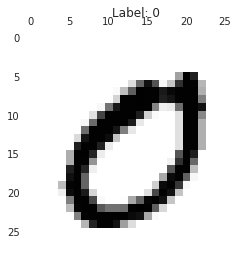

In [12]:
rand_example = training_examples.index[3]
_, ax = plt.subplots()
ax.matshow(training_examples.loc[rand_example].values.reshape(28, 28))
ax.set_title("Label: %i" % training_targets.loc[rand_example])
ax.grid(False)

In [13]:
rand = training_examples.loc[rand_example]
rand = rand.reshape(28,28)

/home/rainbowww5/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


## got a sample from the training_examples, transform it into a image the mobilenet will read.

/home/rainbowww5/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


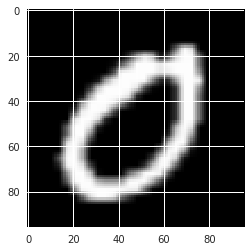

In [14]:
t = adjust_image(rand)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
img = sess.run(t)
plt.imshow(img.squeeze())

In [15]:


train_input_layer = adjust_image(training_examples)
val_input_layer = adjust_image(validation_examples)

# train_outputs = module(train_input_layer)
# val_outputs = module(val_input_layer)

# train_logits = tf.layers.dense(inputs=train_outputs, units=10)
# val_logits = tf.layers.dense(inputs=val_outputs, units=10)

training_examples = sess.run(train_input_layer)
validation_examples = sess.run(val_input_layer)
type(training_examples)
type(validation_examples)

numpy.ndarray

In [16]:
classifier = train_hub_classification_model(
    learning_rate=1.5,
    steps=1000,
    batch_size=100,
    hidden_units=[100, 100],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

predict input fn
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'int'>
predict input fn
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'int'>
training input fn
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'int'>
predict input fn
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'int'>
predict input fn
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'int'>
training input fn
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'int'>
Training model...
LogLoss error (on validation data):


InvalidArgumentError: Received a label value of -9223372036854775808 which is outside the valid range of [0, 10).  Label values: -9223372036854775808 -9223372036854775808 1 9 2 5 2 1 0 1 6 9 8 1 4 -9223372036854775808 8 7 4 3 0 7 2 2 8 -9223372036854775808 -9223372036854775808 0 3 -9223372036854775808 4 8 -9223372036854775808 2 4 -9223372036854775808 1 -9223372036854775808 0 2 -9223372036854775808 1 8 7 8 -9223372036854775808 -9223372036854775808 2 1 5 6 7 6 6 -9223372036854775808 6 6 4 8 3 -9223372036854775808 7 -9223372036854775808 9 -9223372036854775808 4 3 1 1 7 7 1 9 -9223372036854775808 7 3 0 1 1 -9223372036854775808 -9223372036854775808 -9223372036854775808 2 2 -9223372036854775808 8 5 -9223372036854775808 -9223372036854775808 9 6 7 -9223372036854775808 8 1 8 6 3 1 6
	 [[Node: sparse_softmax_cross_entropy_loss/xentropy/xentropy = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense/BiasAdd, random_shuffle_queue_DequeueMany:2)]]

Caused by op 'sparse_softmax_cross_entropy_loss/xentropy/xentropy', defined at:
  File "/home/rainbowww5/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/rainbowww5/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-bde1ee4ec90b>", line 9, in <module>
    validation_targets=validation_targets)
  File "<ipython-input-8-6c4cf308a418>", line 41, in train_hub_classification_model
    steps=steps_per_period
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/estimator/estimator.py", line 363, in train
    loss = self._train_model(input_fn, hooks, saving_listeners)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/estimator/estimator.py", line 843, in _train_model
    return self._train_model_default(input_fn, hooks, saving_listeners)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/estimator/estimator.py", line 856, in _train_model_default
    features, labels, model_fn_lib.ModeKeys.TRAIN, self.config)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/estimator/estimator.py", line 831, in _call_model_fn
    model_fn_results = self._model_fn(features=features, **kwargs)
  File "<ipython-input-4-d99a22ae0dee>", line 21, in mobilenet_model_fn
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/losses/losses_impl.py", line 853, in sparse_softmax_cross_entropy
    name="xentropy")
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 2050, in sparse_softmax_cross_entropy_with_logits
    precise_logits, labels, name=name)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 7479, in sparse_softmax_cross_entropy_with_logits
    labels=labels, name=name)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/rainbowww5/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Received a label value of -9223372036854775808 which is outside the valid range of [0, 10).  Label values: -9223372036854775808 -9223372036854775808 1 9 2 5 2 1 0 1 6 9 8 1 4 -9223372036854775808 8 7 4 3 0 7 2 2 8 -9223372036854775808 -9223372036854775808 0 3 -9223372036854775808 4 8 -9223372036854775808 2 4 -9223372036854775808 1 -9223372036854775808 0 2 -9223372036854775808 1 8 7 8 -9223372036854775808 -9223372036854775808 2 1 5 6 7 6 6 -9223372036854775808 6 6 4 8 3 -9223372036854775808 7 -9223372036854775808 9 -9223372036854775808 4 3 1 1 7 7 1 9 -9223372036854775808 7 3 0 1 1 -9223372036854775808 -9223372036854775808 -9223372036854775808 2 2 -9223372036854775808 8 5 -9223372036854775808 -9223372036854775808 9 6 7 -9223372036854775808 8 1 8 6 3 1 6
	 [[Node: sparse_softmax_cross_entropy_loss/xentropy/xentropy = SparseSoftmaxCrossEntropyWithLogits[T=DT_FLOAT, Tlabels=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense/BiasAdd, random_shuffle_queue_DequeueMany:2)]]


In [ ]:
test = test / 255
test

In [ ]:
def my_test_input_fn(features, batch_size=1, shuffle=True, num_epochs=None):
    raw_features = {"pixels": features.values}
    ds = Dataset.from_tensor_slices((raw_features))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds = ds.shuffle(10000)
    features = ds.make_one_shot_iterator().get_next()
    return features

predict_test_input_fn = lambda: my_test_input_fn(
    test,
    num_epochs=1,
    shuffle=False)

test_predictions = classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['classes'] for item in test_predictions])

In [ ]:
my_submission = pd.DataFrame({'ImageId': test.index + 1, 'Label': test_predictions})
# you could use any filename. We choose submission here
my_submission.to_csv('sub_digit_transfer.csv', index=False)